# Transmission pairs permutation test

June 18, 2020 

We would like to determine whether samples collected in the same geographic area share more variants than expected by chance alone. I am imagining the following permutation test: 

1. Select 2 samples at random. Compute the proportion of total variants between them that are shared. Do this a bunch of times. Make a distribution of results. 
2. Select 2 samples from the same geographic area. Repeat. 
3. Finally, compute the fraction of shared variants between transmission pairs. Plot this as a dotted line on this distribution. This can give you a p-value. 

In [1]:
import imp
import importlib, json
import glob
import re,copy,json
import Bio.Phylo
import requests
import pandas as pd 
import numpy as np

import copy
from scipy.special import binom
import datetime as dt
    
import rpy2
%load_ext rpy2.ipython

## Read in vcfs and convert to dataframes 

I will only read in the intersection SNVs, meaning the ones that were detected in both technical sequencing replicates. This code will separate this into 2 dataframes, 1 for SNVs and 1 for indels, and will also look up and add in the strain names (necessary for converting from tube numbers, which is how the csvs are labelled).

In [2]:
"""to load in an ipython notebook as a module, just run the following. You will now have access to all of the 
functions written in that jupyter notebook"""

%run vcf-module.ipynb

In [3]:
"""now, input the strain names file/metadata file, the directory containing the vcfs, and return the dataframess"""

strain_names_file = "/Users/lmoncla/src/ncov-WI-within-host/data/sample-metadata.tsv"
fasta_file = "/Users/lmoncla/src/ncov-WI-within-host/data/sample-avrl.fasta"
clades_file = "/Users/lmoncla/src/ncov-WI-within-host/data/clades-file-2020-08-28.txt"
vcf_directory = "/Users/lmoncla/src/ncov-WI-within-host/data/vcfs-all/"
samples_to_ignore = ["N_transcript"]

snvs_only, indels_only, all_intersection_variants,metadata_dict = return_dataframes(strain_names_file, clades_file,vcf_directory,samples_to_ignore,fasta_file)

/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

In [4]:
snvs_only.head()

,Unnamed: 0,SNP,POS_x,rep1_percent,rep2_percent,frequency,sampleid,annotation,gene,nt_change,...,aa_site,wt_aa,mut_aa,nt_ref,nt_mut,nuc_muts,minor_frequency,consensus_base,minor_base,minor_nuc_muts
3,8,orf1ab_C>T_Ser2839Ser_synonymous,8782.0,0.9411,0.8919,0.91650,53,synonymous,orf1ab,C>T,...,2839,Ser,Ser,C,T,C8782T,0.08350,T,C,T8782C
6,15,orf1ab_T>G_Met4958Arg_missense,15137.0,0.0173,0.0129,0.01510,53,missense,orf1ab,T>G,...,4958,Met,Arg,T,G,T15137G,0.01510,T,G,T15137G
7,16,orf1ab_A>C_Thr4959Pro_missense,15139.0,0.0184,0.0219,0.02015,53,missense,orf1ab,A>C,...,4959,Thr,Pro,A,C,A15139C,0.02015,A,C,A15139C
8,17,orf1ab_G>T_Gln4962His_missense,15150.0,0.0259,0.0304,0.02815,53,missense,orf1ab,G>T,...,4962,Gln,His,G,T,G15150T,0.02815,G,T,G15150T
9,18,orf1ab_T>G_Leu4968Trp_missense,15167.0,0.0103,0.0109,0.01060,53,missense,orf1ab,T>G,...,4968,Leu,Trp,T,G,T15167G,0.01060,T,G,T15167G


In [5]:
snvs_to_query = set(snvs_only['minor_nuc_muts'])
indels_to_query = set(indels_only['minor_nuc_muts'])
all_variants_to_query = snvs_to_query.copy()
all_variants_to_query.update(indels_to_query)
print(len(snvs_to_query))
print(len(indels_to_query))
print(len(all_variants_to_query))

376
124
500


## Enumerate groups of sequences that are identical at consensus level 

In addition to the transmission pairs permutation test, I would also like to look at whether samples that are identical to each other at consensus are also more similar within-host

In [6]:
high_freq_only = all_intersection_variants[all_intersection_variants['frequency']>=0.5]
high_freq_only['mutation'] = high_freq_only['nt_change'] + high_freq_only['POS_x'].astype(int).astype(str)

high_freq_variants_dict = {}

for sample in set(all_intersection_variants['strain_name'].tolist()):
    x = high_freq_only[high_freq_only['strain_name'] == sample]
    variants = set(x['mutation'].tolist())
    high_freq_variants_dict[sample] = variants
    
#high_freq_variants_dict

/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [7]:
high_freq_variants_dict.get('USA/WI-UW-34/2020') - high_freq_variants_dict.get('USA/WI-UW-160/2020')

{'C>T20316',
 'C>T26124',
 'C>T8782',
 'END29742',
 'G>A16381',
 'G>A28878',
 'G>T25500',
 'T>C17877',
 'T>C28144'}

In [8]:
group_master = []
for k,v in high_freq_variants_dict.items():
    local_group = []
    for i,j in high_freq_variants_dict.items():
        if k != i:
            if len(v - j) == 0 and len(j-v) == 0:
                local_group.append(i)
    local_group.append(k)
    
    local_group_set = set(local_group)
    if local_group_set not in group_master:
        group_master.append(local_group_set)

#group_master

## Code up the permutation test

In [6]:
def pick_2_random_numbers(list_to_sample_from):
    
    import random
    selections = random.sample(list_to_sample_from, 2)
    return(selections[0],selections[1])

In [7]:
def compute_shared_variant_proportion(sample1,sample2,df):
    shared_variants = 0
    
    s1_df = df[df['strain_name'] == sample1]
    variants_in_s1 = set(s1_df['minor_nuc_muts'].tolist())
    
    s2_df = df[df['strain_name'] == sample2]
    variants_in_s2 = set(s2_df['minor_nuc_muts'].tolist())
    
    total_variants = len(variants_in_s1) + len(variants_in_s2)
    if total_variants == 0:
        proportion_shared = 0
    
    else:
        for v in variants_in_s1:
            if v in variants_in_s2:
                shared_variants += 2
            
        proportion_shared = float(shared_variants/total_variants)
        number_shared = shared_variants
            
    return(proportion_shared, number_shared)

In [8]:
def run_permutation_test(iterations, df_to_run):
    
    # run a bunch of times
    output_prop_list = []
    output_number_list = []

    for i in range(iterations):
        # query all strains
        list_to_query = set(df_to_run['strain_name'].tolist())
        s1,s2 = pick_2_random_numbers(list_to_query)
    
        # with those random pairs of samples, compute the proportion of snvs that are shared
        proportion_variants_shared,number_variants_shared = compute_shared_variant_proportion(s1,s2,df_to_run)
        output_prop_list.append(proportion_variants_shared)
        output_number_list.append(number_variants_shared)
        
    # return dataframes
    output_prop_df = pd.DataFrame(output_prop_list)
    output_prop_df.columns = ['proportion_shared']
    
    output_number_df = pd.DataFrame(output_number_list)
    output_number_df.columns = ['number_shared']

    return(output_prop_list, output_number_list, output_prop_df, output_number_df)

### Geo permutation test

In this version of the test, we will only compare samples that have the same geographic location

In [9]:
def run_permutation_test_shared_trait(iterations, df_to_run, metadata, trait):
    
    count = 0
    output_prop_list = []
    output_number_list = []
    list_to_query = set(df_to_run['strain_name'].tolist())

    while count < iterations:
        s1,s2 = pick_2_random_numbers(list_to_query)
    
        # with those random pairs of samples, compute the proportion of snvs that are shared
        if s1 in metadata and s2 in metadata: 
            trait1 = metadata[s1][trait]
            trait2 = metadata[s2][trait]
            
            if trait1 == trait2 and "unknown" not in [trait1,trait2]:
                proportion_variants_shared,number_variants_shared = compute_shared_variant_proportion(s1,s2,df_to_run)
                output_prop_list.append(proportion_variants_shared)
                output_number_list.append(number_variants_shared)
                count += 1
            else:
                pass
        
    # return dataframe
    output_prop_df = pd.DataFrame(output_prop_list)
    output_prop_df.columns = ['proportion_shared']
    
    output_number_df = pd.DataFrame(output_number_list)
    output_number_df.columns = ['number_shared']
    
    return(output_prop_list, output_number_list, output_prop_df, output_number_df)

## Compute p-values for transmission pairs 

For each transmission pair, compute the proportion of variants shared, and compare to the fraction of random pairs that have at least that much shared variation

In [10]:
def compute_p_value(proportion_variants_shared, list_of_permuted_shared_proportions):
    count = 0
    for p in list_of_permuted_shared_proportions:
        if p >= proportion_variants_shared:
            count += 1
            
    fraction_more_extreme = count/len(list_of_permuted_shared_proportions)
    return(fraction_more_extreme)

In [11]:
def compute_p_values_for_transmission_pairs(transmission_pairs, df_with_variants, list_of_permuted_shared_proportions):
    
    shared_fractions = []
    p_values = []

    for t in transmission_pairs:
        sample1 = t[0]
        sample2 = t[1]
        proportion_variants_shared,number_variants_shared = compute_shared_variant_proportion(sample1,sample2,df_with_variants)

        # now calculate the number of random pairs with at least as much shared variation as the transmission pair
        fraction_more_extreme = compute_p_value(proportion_variants_shared, list_of_permuted_shared_proportions)

        shared_fractions.append(proportion_variants_shared)
        p_values.append(fraction_more_extreme)
        
    return(shared_fractions,p_values)

In [12]:
def generate_df2(shared_fractions,p_values):
    y_limit = 3200
    y_limits = [y_limit] * 6
    shared_fractions_dict = {"pair":["1","2","3", "4", "5", "6"],
                         "fraction_shared":shared_fractions,
                        "y":y_limits,
                        "p_value":p_values}
    df2 = pd.DataFrame.from_dict(shared_fractions_dict)
    df2['color'] = np.where(df2['p_value'] < 0.05, "significant","not")
    
    return(df2)

## Run!

In [13]:
# make a combined dataframe with indels and snvs
s = snvs_only[["strain_name","minor_nuc_muts","frequency","sampleid","location"]]
i = indels_only[["strain_name","minor_nuc_muts","frequency","sampleid","location"]]
combined_df = s.append(i)
combined_df.head()

,strain_name,minor_nuc_muts,frequency,sampleid,location
3,USA/WI-UW-67/2020,T8782C,0.91650,53,Dane County
6,USA/WI-UW-67/2020,T15137G,0.01510,53,Dane County
7,USA/WI-UW-67/2020,A15139C,0.02015,53,Dane County
8,USA/WI-UW-67/2020,G15150T,0.02815,53,Dane County
9,USA/WI-UW-67/2020,T15167G,0.01060,53,Dane County


In [14]:
# other dataframes to run
# high_freq_snvs_only = snvs_only[snvs_only['frequency'] >= 0.50]
# low_freq_indels_snvs = low_freq_indels_only.append(low_freq_snvs_only)
# all_indels_snvs = snvs_only.append(low_freq_indels_only)  # high freq indels don't exit

In [19]:
tlist = []
for t in transmission_pairs: 
    tlist.append(t[0])
    tlist.append(t[1])
    
sloth = combined_df[combined_df['strain_name'].isin(tlist)]
#sloth

The putative transmission pairs are: 
1. USA/WI-UW-65/2020 and USA/WI-UW-32/2020  (2 days apart)(tubes 50 and 8)
2. USA/WI-UW-41/2020 and USA/WI-UW-48/2020 (same day)(tubes 20 and 28)
3. USA/WI-UW-74/2020 and USA/WI-UW-29/2020 (4 days apart)(tubes 61 and 5)
4. USA/WI-UW-120/2020 and USA/WI-UW-119/2020 (3 days apart)(tubes 130 and 128)
5. USA/WI-UW-333/2020 and USA/WI-UW-334/2020 (same day)(tubes 453 and 454)
6. USA/WI-UW-337/2020 and USA/WI-UW-338/2020 (same day)(tubes 56 and 53) -> I am actually excluding these, because they do not have the same consensus sequence; they are 3 mutations different, which seems pretty unlikely
7. USA/WI-UW-158/2020 and USA/WI-UW-159/2020 and USA/WI-UW-160/2020 (tubes 195,196,197) (these are all in the same household, all collected on the same day) -> I am also going to call 158 and 160 true transmission pairs because they have the same consensus sequence, while 159 has 2 additional mutations (158 and 160 isolated same day). 159 does look like it be descendant from 158 and 160, but becuase it has 2 mutations different tthey were all collected on the same day, it seems a little weird.

pairs 5 and 6 are from the Milwaukee area, whereas the rest are more from the Madison area

In [15]:
transmission_pairs = [["USA/WI-UW-65/2020","USA/WI-UW-32/2020"],["USA/WI-UW-41/2020","USA/WI-UW-48/2020"],
                      ["USA/WI-UW-74/2020","USA/WI-UW-29/2020"],["USA/WI-UW-120/2020","USA/WI-UW-119/2020"],
                     ["USA/WI-UW-333/2020","USA/WI-UW-334/2020"],["USA/WI-UW-158/2020","USA/WI-UW-160/2020"]]

In [66]:
n_iterations = 10000
df_to_run = s

In [67]:
# run it for all pairs
proportions, number, proportions_df, number_df = run_permutation_test(n_iterations, df_to_run)

shared_fractions_trans_pairs,p_values_random_pairs = compute_p_values_for_transmission_pairs(transmission_pairs, df_to_run, proportions)
percentile_random_pairs = np.percentile(proportions_df['proportion_shared'], 95)
df2_random = generate_df2(shared_fractions_trans_pairs,p_values_random_pairs)

In [68]:
# run it for same location pairs 
trait = "location"
proportions_geo, number_geo, proportions_geo_df,number_geo_df= run_permutation_test_shared_trait(n_iterations, df_to_run, metadata_dict,trait)

shared_fractions_trans_pairs,p_values_same_geo = compute_p_values_for_transmission_pairs(transmission_pairs, df_to_run, proportions_geo)
percentile_same_geo = np.percentile(proportions_geo_df['proportion_shared'], 95)
df2_same_geo = generate_df2(shared_fractions_trans_pairs,p_values_same_geo)

In [69]:
# run it for same clade pairs 
trait = "clade"
proportions_clade, number_clade, proportions_clade_df,number_clade_df= run_permutation_test_shared_trait(n_iterations, df_to_run, metadata_dict,trait)

shared_fractions_trans_pairs,p_values_same_clade = compute_p_values_for_transmission_pairs(transmission_pairs, df_to_run, proportions_clade)
percentile_same_clade = np.percentile(proportions_clade_df['proportion_shared'], 95)
df2_same_clade = generate_df2(shared_fractions_trans_pairs,p_values_same_clade)

In [70]:
Dane_df = df_to_run[df_to_run['location'] == "Dane County"]
Milwaukee_df = df_to_run[df_to_run['location'] == "Milwaukee County"]

print(len(set(Dane_df['strain_name'].tolist())), len(set(Milwaukee_df['strain_name'].tolist())))

Dane_proportions,Dane_numbers,Dane_proportions_df,Dane_number_df = run_permutation_test(n_iterations, Dane_df)
MK_proportions,MK_nunber,MK_proportions_df,MK_number_df = run_permutation_test(n_iterations, Milwaukee_df)

44 39


In [71]:
# pair3 = snvs_only[snvs_only['strain_name'].isin(["USA/WI-UW-74/2020","USA/WI-UW-29/2020"])]
# pair3

In [72]:
# pair4 = snvs_only[snvs_only['strain_name'].isin(["USA/WI-UW-120/2020","USA/WI-UW-119/2020"])]
# pair4

# Plot!

In [73]:
random_pair_color = "#C4C4C5"
sig_color =  "#2664A5" #"#70AE9D"
not_sig_color = "#4A4A4A" # "#AE7081"
same_geo_color = "#FEEDBE"

## Random pairs

In [74]:
df2_random

,pair,fraction_shared,y,p_value,color
0,1,0.000000,3200,1.0000,not
1,2,0.434783,3200,0.0762,not
2,3,1.000000,3200,0.0001,significant
3,4,0.333333,3200,0.1973,not
4,5,0.285714,3200,0.2637,not
5,6,0.370370,3200,0.1338,not


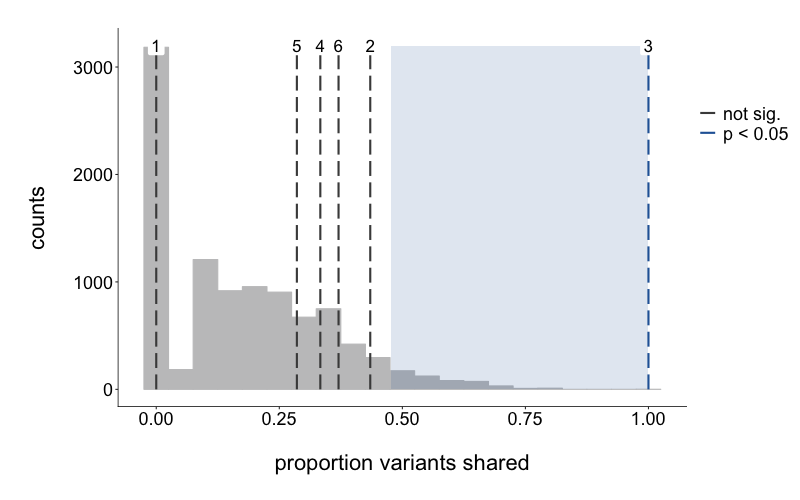

In [75]:
%%R -w 800 -h 500 -u px -i proportions_df,df2_random,percentile_random_pairs,random_pair_color,sig_color,not_sig_color  # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)

legend_x = 1.1
legend_y = 0.75
y_end = df2_random$y[[1]]

p <- ggplot() + 
    geom_histogram(data=proportions_df, aes(x=proportion_shared), binwidth=0.05, color=random_pair_color, fill=random_pair_color)+
    geom_rect(aes(xmin=percentile_random_pairs, xmax=1.0, ymin=0, ymax=y_end),color=NaN,fill=sig_color, alpha=0.15)+
    #geom_segment(aes(x=percentile,xend=percentile,y=0,yend=y_end,color=percentile_color),size=1,linetype=1)+
    geom_segment(data=df2_random, aes(x=fraction_shared,xend=fraction_shared,y=0,yend=y,color=color),size=1,linetype=5)+
    geom_label(data=df2_random, aes(x=fraction_shared,y=y,label=pair),label.size=NA, size=6)+
    labs(x="\nproportion variants shared",y="counts\n")+
    scale_color_manual(values=c(significant=sig_color,not=not_sig_color), labels=c(" not sig."," p < 0.05"))+
#     scale_fill_manual(values=c(arose_on_tip=tip_color,arose_on_internal_node=node_color), labels=c("tip", "internal node"))+
#    scale_y_continuous(breaks=seq(0,35,5), limits=c(0,35))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=22, vjust=5))+
    theme(axis.text.y=element_text(size=18, colour="black"))+
    theme(axis.text.x=element_text(size=18, colour="black", hjust=0.5))+
    theme(legend.text=element_text(size=18))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,4,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))+
    theme(legend.position = c(legend_x, legend_y))

ggsave("shared-variants-permutation-test-2020-08-28-snvs.pdf", width = 10, height = 6, device = "pdf", path = "/Users/lmoncla/src/ncov-WI-within-host/figures/", dpi = 300)
p

## Plot with geo as well

In [76]:
x = proportions_df
x['test'] = "all"
y = proportions_geo_df
y['test'] = "same"
proportions_combined_df = x.append(y)

In [77]:
print(proportions_df["proportion_shared"].mean(), proportions_geo_df["proportion_shared"].mean())
print(proportions_df["proportion_shared"].median(), proportions_geo_df["proportion_shared"].median())

0.17525002495955436 0.1915480763748554
0.15384615384615385 0.15384615384615385


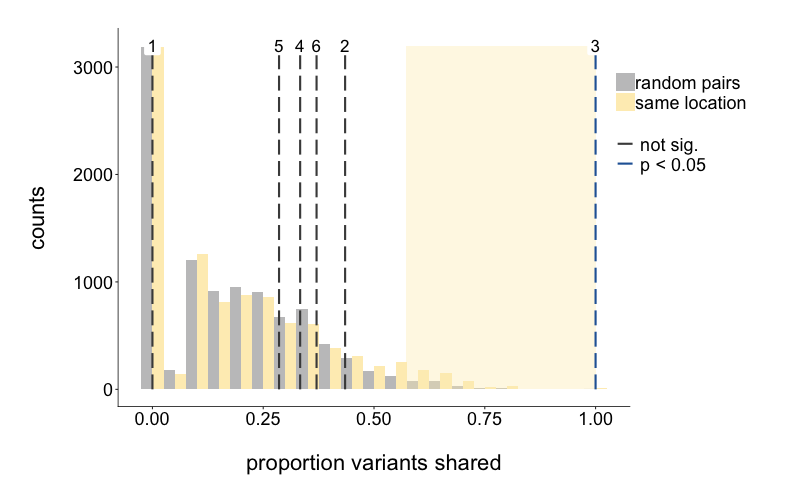

In [78]:
%%R -w 800 -h 500 -u px -i proportions_combined_df,df2_same_geo,percentile_same_geo,random_pair_color,sig_color,not_sig_color,same_geo_color  # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)

y_end = df2_same_geo$y[[1]]

p <- ggplot() + 
    geom_histogram(data=proportions_combined_df, aes(x=proportion_shared,fill=test), binwidth=0.05, position="dodge")+
    #geom_rect(aes(xmin=percentile, xmax=1.0, ymin=0, ymax=y_end),color=NaN,fill=sig_color, alpha=0.1)+
    geom_rect(aes(xmin=percentile_same_geo, xmax=1.0, ymin=0, ymax=y_end),color=NaN,fill=same_geo_color, alpha=0.4)+
    #geom_segment(aes(x=percentile,xend=percentile,y=0,yend=y_end,color=percentile_color),size=1,linetype=1)+
    geom_segment(data=df2_same_geo, aes(x=fraction_shared,xend=fraction_shared,y=0,yend=y_end,color=color),size=1,linetype=5)+
    geom_label(data=df2_same_geo, aes(x=fraction_shared,y=y,label=pair),label.size=NA, size=6)+
    labs(x="\nproportion variants shared",y="counts\n")+
    scale_color_manual(values=c(significant=sig_color,not=not_sig_color), labels=c(not=" not sig.",significant=" p < 0.05"))+
    scale_fill_manual(values=c(significant=sig_color,not=not_sig_color,all=random_pair_color,same=same_geo_color), labels=c(all="random pairs",same="same location"))+
#    scale_y_continuous(breaks=seq(0,35,5), limits=c(0,35))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=22, vjust=5))+
    theme(axis.text.y=element_text(size=18, colour="black"))+
    theme(axis.text.x=element_text(size=18, colour="black", hjust=0.5))+
    theme(legend.text=element_text(size=18))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,6,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))+
    theme(legend.position = c(1.1, 0.75))

ggsave("shared-variants-geo-permutation-test-2020-08-28-snvs.pdf", width = 10, height = 6, device = "pdf", path = "/Users/lmoncla/src/ncov-WI-within-host/figures/", dpi = 300)
p

## Plot for clades same

In [79]:
x = proportions_df
x['test'] = "all"
y = proportions_clade_df
y['test'] = "same"
proportions_combined_df = x.append(y)

In [80]:
print(proportions_df["proportion_shared"].mean(), proportions_clade_df["proportion_shared"].mean())
print(proportions_df["proportion_shared"].median(), proportions_clade_df["proportion_shared"].median())

0.17525002495955436 0.27217495895090654
0.15384615384615385 0.2727272727272727


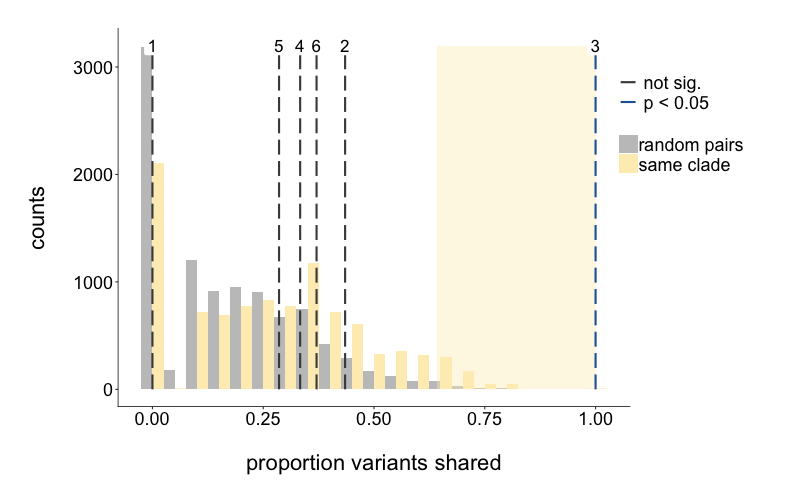

In [81]:
%%R -w 800 -h 500 -u px -i proportions_combined_df,df2_same_clade,percentile_same_clade,random_pair_color,sig_color,not_sig_color,same_geo_color  # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)

y_end = df2_same_clade$y[[1]]

p <- ggplot() + 
    geom_histogram(data=proportions_combined_df, aes(x=proportion_shared,fill=test), binwidth=0.05, position="dodge")+
    #geom_rect(aes(xmin=percentile, xmax=1.0, ymin=0, ymax=y_end),color=NaN,fill=sig_color, alpha=0.1)+
    geom_rect(aes(xmin=percentile_same_clade, xmax=1.0, ymin=0, ymax=y_end),color=NaN,fill=same_geo_color, alpha=0.4)+
    #geom_segment(aes(x=percentile,xend=percentile,y=0,yend=y_end,color=percentile_color),size=1,linetype=1)+
    geom_segment(data=df2_same_clade, aes(x=fraction_shared,xend=fraction_shared,y=0,yend=y_end,color=color),size=1,linetype=5)+
    geom_label(data=df2_same_clade, aes(x=fraction_shared,y=y,label=pair),label.size=NA, size=6)+
    labs(x="\nproportion variants shared",y="counts\n")+
    scale_color_manual(values=c(significant=sig_color,not=not_sig_color,all=random_pair_color,same=same_geo_color), labels=c(not=" not sig.",significant=" p < 0.05"))+
    scale_fill_manual(values=c(significant=sig_color,not=not_sig_color,all=random_pair_color,same=same_geo_color), labels=c(all="random pairs",same="same clade"))+
#    scale_y_continuous(breaks=seq(0,35,5), limits=c(0,35))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=22, vjust=5))+
    theme(axis.text.y=element_text(size=18, colour="black"))+
    theme(axis.text.x=element_text(size=18, colour="black", hjust=0.5))+
    theme(legend.text=element_text(size=18))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,6,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))+
    theme(legend.position = c(1.1, 0.75))

ggsave("shared-variants-clade-permutation-test-2020-08-28-snvs.pdf", width = 10, height = 6, device = "pdf", path = "/Users/lmoncla/src/ncov-WI-within-host/figures/", dpi = 300)
p

In [ ]:
x = proportions_df
x['test'] = "all"
y = Dane_proportions_df
y['test'] = "Dane"
z = MK_proportions_df
z['test'] = "Milwaukee"
proportions_combined_df = x.append(y.append(z))

In [ ]:
%%R -w 800 -h 500 -u px -i proportions_combined_df,df2,pair1_shared,pair2_shared,pair3_shared,pair4_shared,pair5_shared,pair6_shared  # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)

y_end = 2400
p <- ggplot(data=proportions_combined_df, aes(x=proportion_shared, color=test,fill=test)) + 
    geom_histogram(binwidth=0.05, position='dodge')+
    geom_segment(x=pair1_shared,xend=pair1_shared,y=0,yend=y_end, color="dodgerblue", size=1.25, linetype=5)+
    geom_segment(x=pair2_shared,xend=pair2_shared,y=0,yend=y_end, color="dodgerblue", size=1.25, linetype=5)+
    geom_segment(x=pair3_shared,xend=pair3_shared,y=0,yend=y_end, color="dodgerblue", size=1.25, linetype=5)+
    geom_segment(x=pair4_shared,xend=pair4_shared,y=0,yend=y_end, color="dodgerblue", size=1.25, linetype=5)+
    geom_segment(x=pair5_shared,xend=pair5_shared,y=0,yend=y_end, color="dodgerblue", size=1.25, linetype=5)+
    geom_segment(x=pair6_shared,xend=pair6_shared,y=0,yend=y_end, color="dodgerblue", size=1.25, linetype=5)+
    #geom_label(data=df2, aes(x=fraction_shared,y=y,label=pair),label.size=NA, size=6)
    labs(x="\nproportion variants shared among random pairs",y="counts\n")+
    scale_color_manual(values=c("grey60","burlywood1","burlywood3"), guide=FALSE)+
    scale_fill_manual(values=c("grey60","burlywood1","burlywood3"))+
# #    scale_y_continuous(breaks=seq(0,35,5), limits=c(0,35))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=22, vjust=5))+
    theme(axis.text.y=element_text(size=18, colour="black"))+
    theme(axis.text.x=element_text(size=18, colour="black", hjust=0.95))+
    theme(legend.text=element_text(size=18))+
    theme(legend.title=element_text(size=22))+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,4,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))+
    theme(legend.position = c(1.0, 0.75))+

ggsave("shared-variants-Dane-MK-all-permutation-test-2020-08-21-snvs.pdf", width = 12, height = 6, device = "pdf", path = "/Users/lmoncla/src/ncov-WI-within-host/figures/", dpi = 300)
p

## Now, instead, try looking at clusters I have identified based on looking like transmission chains 

cluster 1 is roughy 19A and cluster 2 is roughly 19B

In [277]:
cluster_df = pd.DataFrame.from_csv("/Users/lmoncla/src/ncov-WI-within-host/data/annotations-2020-08-21.csv")
cluster_df.reset_index(inplace=True)
cluster_df = cluster_df.rename(columns={"name": "strain_name"})
cluster_df.head()

/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """Entry point for launching an IPython kernel.


,strain_name,cluster,number_cluster_muts,total_non_single_muts_in_cluster,total_strain_in_cluster
0,USA/WI-UW-217/2020,1,6.0,27,25
1,USA/WI-UW-246/2020,1,6.0,27,25
2,USA/WI-UW-231/2020,1,4.0,27,25
3,USA/WI-UW-306/2020,1,7.0,27,25
4,USA/WI-UW-232/2020,1,5.0,27,25


In [278]:
all_clusters_df = pd.DataFrame()
iterations = 10000

for cluster_number in set(cluster_df['cluster'].tolist()):
    subset_cluster = cluster_df[cluster_df['cluster'] == cluster_number]
    subset_cluster_df = snvs_only[snvs_only['strain_name'].isin(subset_cluster['strain_name'].tolist())]
    
    cluster_prop_list,cluster_number_list, cluster_prop_df,cluster_number_df = run_permutation_test(iterations, subset_cluster_df)
    
    cluster_prop_df['test'] = str(cluster_number)
    all_clusters_df = all_clusters_df.append(cluster_prop_df)

In [279]:
all_clusters_df.head()

,proportion_shared,test
0,0.181818,1
1,0.384615,1
2,0.400000,1
3,0.230769,1
4,0.266667,1


In [280]:
x = all_clusters_df
y = proportions_df
y['test'] = "all"
combined_df = x.append(y)

# combined_df = combined_df[combined_df['test'] != "7"]
# combined_df = combined_df[combined_df['test'] != "6"]
# combined_df = combined_df[combined_df['test'] != "5"]
# combined_df = combined_df[combined_df['test'] != "4"]
# combined_df = combined_df[combined_df['test'] != "3"]

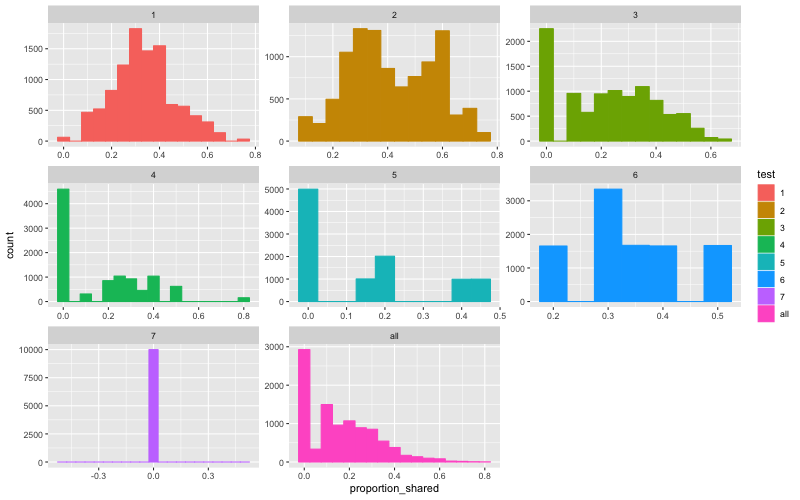

In [290]:
%%R -w 800 -h 500 -u px -i combined_df,df2 # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)

y_end = 2400
p <- ggplot(data=combined_df, aes(x=proportion_shared, color=test,fill=test)) + 
    facet_wrap(~test, scales="free")+
    geom_histogram(binwidth=0.05, position='dodge')
#     geom_segment(data=df2, aes(x=fraction_shared,xend=fraction_shared,y=0,yend=y_end),size=1,linetype=5)+
#     geom_label(data=df2, aes(x=fraction_shared,y=y,label=pair),label.size=NA, size=6)+
#     labs(x="\nproportion variants shared among pairs",y="counts\n")+
#     scale_color_manual(values=c("steelblue","steelblue4","grey60"), guide=FALSE)+
#     scale_fill_manual(values=c("steelblue","steelblue4","grey60"))+
# # #    scale_y_continuous(breaks=seq(0,35,5), limits=c(0,35))+
#     theme(panel.grid.major=element_line(colour=NA,size=NA))+    
#     theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
#     theme(strip.background = element_rect(colour=NA, fill=NA))+
#     theme(axis.line.x=element_line(colour="black"))+
#     theme(axis.line.y=element_line(colour="black"))+
#     theme(axis.title=element_text(size=22, vjust=5))+
#     theme(axis.text.y=element_text(size=18, colour="black"))+
#     theme(axis.text.x=element_text(size=18, colour="black", hjust=0.95))+
#     theme(legend.text=element_text(size=18))+
#     theme(legend.title=element_text(size=22))+
#     theme(panel.margin=unit(1, "lines"))+
#     theme(plot.margin=unit(c(1,4,1,1),"cm"))+
#     theme(legend.key.size=unit(0.7, "cm"))+
#     theme(panel.background=element_rect(fill=NA))+
#     theme(legend.key=element_rect(fill=NA))+
#     theme(legend.position = c(1.0, 0.75))

ggsave("shared-variants-clusters-permutation-test-2020-08-28-snvs.pdf", width = 12, height = 6, device = "pdf", path = "/Users/lmoncla/src/ncov-WI-within-host/figures/", dpi = 300)
p